# (E5) 소리 단어 구별



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random
# 데이터로드
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# rand = random.randint(0,len(speech_data["wav_vals"]))
sr = 8000 # 1초동안 재생되는 샘플의 갯수

## 1. 데이터 처리와 분류
### 라벨데이터 처리하기



In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
# print(speech_data["wav_vals"])

In [4]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(label_data)
# print(label_value.shape)

[ 3  3  3 ... 11 11 11]


### waveform을 spectrogram으로 변환 

In [4]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [5]:
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)
print("Waveform shape : ",speech_data["wav_vals"].shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (50620, 8000)
Spectrogram shape :  (50620, 130, 126)


### sklearn의 train_test_split 사용하여 train,test분리(spectrogram용)

In [6]:
from sklearn.model_selection import train_test_split

# sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec.shape)

# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
# test_wav = test_wav.reshape([-1, sr, 1])
print(train_spec.shape)
print(test_spec.shape)
print(train_label.shape)
# speech_data["wav_vals"][0][100]
# print(speech_data["wav_vals"][50619])
# len(speech_data["wav_vals"][50620])
del speech_data
del spec

(45558, 130, 126)
(45558, 130, 126)
(5062, 130, 126)
(45558,)


### 2. 학습을 위한 하이퍼파라미터 설정


In [7]:
batch_size = 12
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj26/aiffel/speech_recognition/models/wav'

### 3. 데이터셋 구성
- tf.data.Dataset 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플(data,label)형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워주기


In [8]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [9]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


### 4. 2차원 Spectrogram 처리 모델 구성
- 2차원 Spectrogram 데이터 Conv2D layer를 적용 
- batchnorm,dropout,dense layer 등을 이용 
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보기


In [10]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [12]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [13]:
#30분 내외 소요
a = len(train_spec) // batch_size
b = len(test_spec) // batch_size
del train_spec
# del test_spec
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch= a,
                    validation_data=test_dataset,
                    validation_steps= b,
                    callbacks=[cp_callback]
                    )


Epoch 1/10
3796/3796 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.7502
Epoch 00001: val_loss improved from inf to 0.34045, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] - 82s 22ms/step - loss: 0.7765 - accuracy: 0.7502 - val_loss: 0.3404 - val_accuracy: 0.8929
Epoch 2/10
3795/3796 [============================>.] - ETA: 0s - loss: 0.2840 - accuracy: 0.9121
Epoch 00002: val_loss improved from 0.34045 to 0.22485, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] - 83s 22ms/step - loss: 0.2840 - accuracy: 0.9121 - val_loss: 0.2249 - val_accuracy: 0.9313
Epoch 3/10
3796/3796 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9445
Epoch 00003: val_loss improved from 0.22485 to 0.15297, saving model to /home/aiffel-dj26/aiffel/speech_recognition/models/wav_skip
3796/3796 [==============================] -

### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
- loss,accuracy를 그래프로 표현


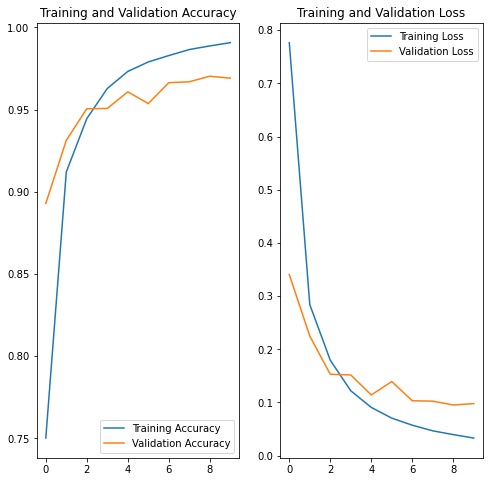

In [14]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 6. Test dataset을 이용해서 모델의 성능을 평가
- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [15]:
model_wav_skip.load_weights(checkpoint_dir)

In [16]:
results = model_wav_skip.evaluate(test_dataset)

422/422 [==============================] - 26s 62ms/step - loss: 0.0953 - accuracy: 0.9702


In [17]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


loss value: 0.095
accuracy value: 97.0170%


In [46]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(b*batch_size, size=1, replace=False)
print(test_spec[batch_index].shape)
print(test_spec[batch_index].reshape(130,126).shape)
batch_xs = test_spec[batch_index]
batch_xs_rs = librosa.istft(test_spec[batch_index].reshape(130,126))
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs_rs.reshape(8000,), rate=8000)

(1, 130, 126)
(130, 126)
label :  yes


In [47]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: yes(Correct!)
✅


(8000,)


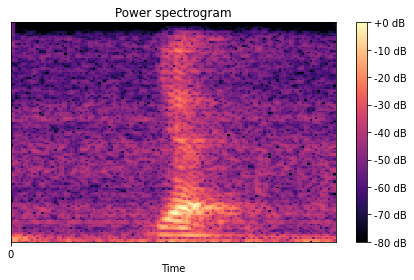

In [53]:
import librosa.display

# print(batch_xs_rs.shape)

librosa.display.specshow(librosa.amplitude_to_db(batch_xs.reshape(130,126), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

소리 구별하는 모델의 결과를 spectrogram 과 wave를 둘다 보고 듣고 할 수 있게 만들었다.

## 고찰

wav를 spectrogram으로 바꾸며 2차원으로 바뀌어  
conv1D에서 conv2D로 모델을 바꾸어주었다.  
사실 이미지를 분석하는 모델과 별 차이 없는데 분석이 가능한게 가장 신기했고  
추가적으로 1D에서하는 모델의 속도보다 조금 더 빠르고 정확한 분석이 되었던게 가장 인상에 남았습니다.  
모델 전처리에서 모델의 유효성(?)이 없어지지 않는다면 차원수를 늘리는 것을 고려해보는 것도 좋은 방법인 것을 배우며 이번 노드는 마무리를 지었습니다.  

---

### 이번의 변화
노드 진행하며 이해 하지 못한 데이터에 Shape를 보고 이해하여 진행하는데 많은 도움이 되었다.  
tensorflow사이트의 함수의 어떤 값이 어떤 역할하는지 보고 이해하는데 조금 능숙해졌다. 하지만 아직 필요한 API를 찾는데 어려움이있다.  
list와np.array의 차이를 느꼈다 자세한건 모르니 좀더 알아봐야할듯하다.